In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

# Part 1: Data Preparation

In [2]:
from generators import data_prep


________________________________________________________________________

Load and Preprocessing DATA:



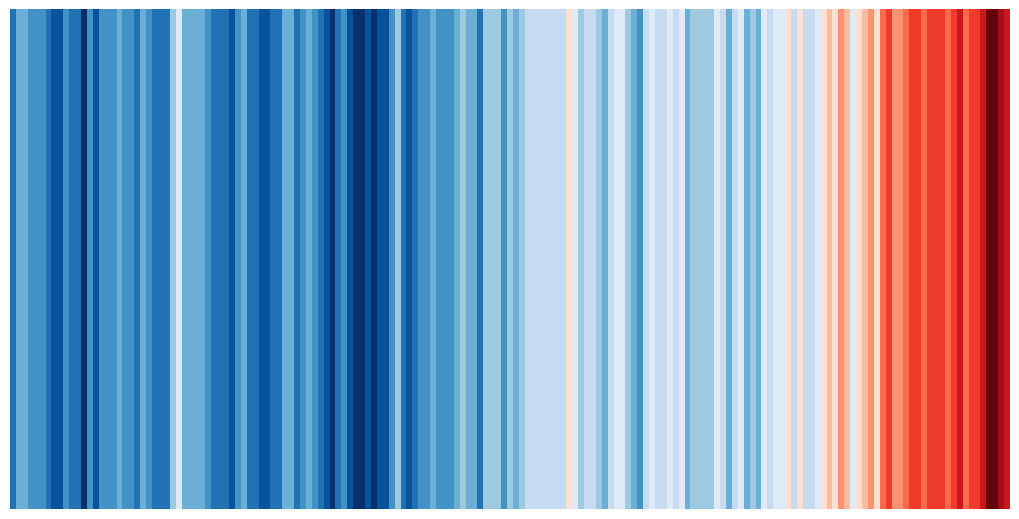

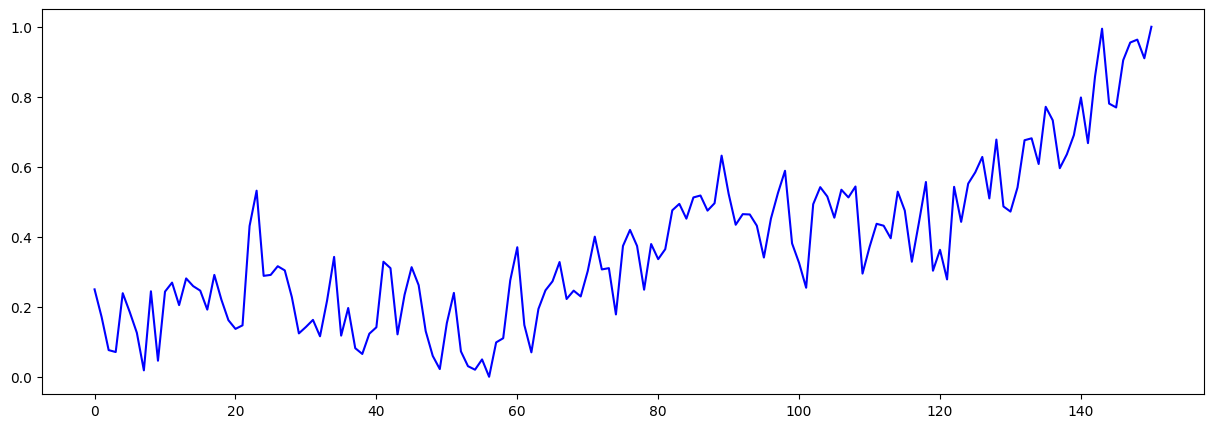

In [3]:
dataset = './data/MetOffice_HadCRUT4.csv'
train_df, valid_df, test_df = data_prep.DATAPREP.prep_stripes(dataset)

# Part 2: Initialize qLSTM

In [4]:
from generators.qlstm_init_model import QuantumLongShortTermMemory, QModel
from generators.data_processing import time_window, time_window_batch
from generators.measurements import create_pauli_ops
from generators.feature_map import FeatureMap_4
from generators.ansatz import VariationalLayer_4
from generators.noise_models import ro_noise_model 
from generators.backends import aer_sv

import numpy as np
import torch

/Users/stefan.kister/quantum coding/qiskit_v10x_coding/.qiskit_v1_venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
# sizes of training windows
length=5
train_window=time_window_batch(train_df,length,  1)
valid_window=time_window_batch(valid_df,length, 1)
test_window=time_window_batch(test_df,length, 1)

# quantum layer parameter
num_qubits = 4
print('Number of Qubits:', num_qubits)
feature_map = FeatureMap_4(num_qubits)
ansatz = VariationalLayer_4(num_qubits)
REPS = 1
backend = aer_sv()
p0given1 = 0.01
p1given0 = 0.01
noise_model = ro_noise_model(p0given1, p1given0)
print('noise_model: ', noise_model)

# lstm model parameter
input_size = 3
hidden_size = 4
seed = 13579
np.random.seed = seed
torch.manual_seed=seed
hidden_dim = 4
n_epochs = 3
target_size = 1
batch_size = 1

print(f"Input dim:    {input_size}")
print(f"LSTM output size: {hidden_dim}")
print(f"Training epochs:  {n_epochs}")


Number of Qubits: 4
noise_model:  NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['measure']
  All-qubits errors: ['measure']
Input dim:    3
LSTM output size: 4
Training epochs:  3


# Train qLSTM model

In [6]:
from qiskit_ibm_runtime import Options

options = Options()
options.execution.shots = 10
shots = 100
hh= True 

while hh:

    model = QModel(input_size,
                hidden_dim,
                target_size,
                noise_model)
    
    loss_function = nn.MSELoss()
    optimizer = optim.RMSprop(model.parameters(), lr=0.01, momentum=0.2)

    model.lstm.clayer_in.requires_grad_(False)
    model.lstm.clayer_out.requires_grad_(False)

    history = {
        'train_loss': [],
        'valid_loss': [],
        'mae': [],
        'mse': []
    }
    for epoch in range(n_epochs):
        train_losses = []
        preds = []
        targets = []
        model.train()
        
        for i,X in enumerate(tqdm(train_window)):

            if i ==len(train_window)-1:
                break;
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()
            # Step 3. Run our forward pass.
            X_in=torch.Tensor(X[0]).reshape((length,batch_size,input_size))
            out_scores = model(X_in)[-1]
        # out_scores = model(X_in)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            # label= torch.Tensor([X[1]]).reshape((length,1))
            label= torch.Tensor([X[1]]).reshape((batch_size,1))
            loss = loss_function(out_scores,label)
            loss.backward()
            optimizer.step()
            train_losses.append(float(loss))

            # probs = torch.softmax(out_scores, dim=-1)
            # preds.append(probs.argmax(dim=-1))
            preds.append(torch.Tensor(out_scores.detach()))
            # targets.append(label[-1])
            targets.append(label)
            
        valid_losses = []
        model.eval()     
        for i,X in enumerate(tqdm(valid_window)):
            if i ==len(valid_window)-1:
                break;
            X_in=torch.Tensor(X[0]).reshape((length,batch_size,input_size))
            try:
                out_scores = model(X_in)[-1]
            except Exception as e:
                print("There was a mistake in the qiskit code: ",e) 
                continue     
            label= torch.Tensor([X[1]]).reshape((batch_size,1))
            loss = loss_function(out_scores,label)
            valid_losses.append(float(loss))

        avg_loss_train = np.mean(train_losses)
        avg_loss_valid = np.mean(valid_losses)
        history['train_loss'].append(avg_loss_train)
        history['valid_loss'].append(avg_loss_valid)
        # print("preds", preds,targets)
        preds = torch.cat(preds)
        targets = torch.cat(targets)
        mean_abs_error = MeanAbsoluteError()
        mae=mean_abs_error(preds, targets)
        mean_sqrt_error = MeanSquaredError()
        mse=mean_sqrt_error(preds, targets)
        history['mae'].append(mae)
        history['mse'].append(mse)
        
        if mae > 0.15:
            hh =True
            break;
        else: 
            hh=False
        print(f"Epoch {epoch + 1} / {n_epochs}: Loss = {avg_loss_train:.3f} Valid Loss: {avg_loss_valid:.3f} MAE = {mae:.4f} MSE = {mse:.4f}")

    

    

TypeError: forward() got an unexpected keyword argument 'feature_map'

In [ ]:
plt.plot(history['train_loss'])
#plt.plot(history['valid_loss'])

In [ ]:
train_predictions=np.array([])
model.eval()
for i,y in enumerate(train_window):
    test_tensor=torch.Tensor(y[0]).reshape((length,batch_size,input_size))
    try:
        pred=model(test_tensor)[-1]
        train_predictions=np.append(train_predictions,pred.detach().numpy())
    except: 
        pred=1
        train_predictions=np.append(train_predictions,pred)

In [ ]:
predictions=np.array([])
test_labels=np.array([])
for i,y in enumerate(test_window):
    test_tensor=torch.Tensor(y[0]).reshape((length,batch_size,input_size))
    try:
        pred=model(test_tensor)[-1]
        predictions=np.append(predictions,pred.detach().numpy())
        test_labels= np.append(test_labels,torch.Tensor([y[1]]).reshape((batch_size,1)))
    except: 
        pred=1
        predictions=np.append(predictions,pred)
        test_labels= np.append(test_labels,torch.Tensor([y[1]]).reshape((batch_size,1)))
t_predictions=torch.from_numpy(predictions)
t_test_labels=torch.from_numpy(test_labels)

mean_abs_error = MeanAbsoluteError()
mae=mean_abs_error(t_predictions, t_test_labels)
mean_sqrt_error = MeanSquaredError()
mse=mean_sqrt_error(t_predictions, t_test_labels)
print("MAE Test",mae)
print("MSE Test",mse)

In [ ]:
valid_labels=np.array([])
valid_predictions=np.array([])
for i,y in enumerate(valid_window):
    test_tensor=torch.Tensor(y[0]).reshape((length,batch_size,input_size))
    try:
        pred=model(test_tensor)[-1]
        valid_predictions=np.append(valid_predictions,pred.detach().numpy())
        valid_labels= np.append(valid_labels,torch.Tensor([y[1]]).reshape((batch_size,1)))
    except: 
        pred=1
        valid_predictions=np.append(valid_predictions,pred)    
        valid_labels= np.append(valid_labels,torch.Tensor([y[1]]).reshape((batch_size,1)))
        
t_predictions=torch.from_numpy(valid_predictions)
t_valid_labels=torch.from_numpy(valid_labels)

mean_abs_error = MeanAbsoluteError()
mae=mean_abs_error(t_predictions, t_valid_labels)
mean_sqrt_error = MeanSquaredError()
mse=mean_sqrt_error(t_predictions, t_valid_labels)
print("MAE Valid",mae)
print("MSE Valid",mse)

In [ ]:
fig = plt.figure(figsize=(10, 1))

ax = fig.add_axes([0, 0, 1, 1])
ax.set_axis_off()

col = PatchCollection([
    Rectangle((y, 0), 1, 1)
    for y in range(+1, LAST + 1)
])

# set data, colormap and color limits

col.set_array(train_df.reshape(-1))
col.set_cmap(cmap)
col.set_clim(reference - LIM, reference + LIM)
ax.add_collection(col)
ax.set_ylim(0, 1)
ax.set_xlim(LAST_VALID+1, LAST + 1)

# plt.figure(figsize=(15,5))
# plt.plot(np.arange(len(train_df[:,0])),train_df[:,0], color='blue', label='Train data')
plt.show()


In [ ]:
####### ZII, IZI, IIZ 
plt.figure(figsize=(16,5))

plt.plot(train_df[:,0], color='black', label='Train data')
plt.plot(length+np.arange(len(train_predictions)),train_predictions, color='black', label='Train Prediction',linestyle='dashed')

plt.plot(len(train_df)+np.arange(len(valid_df)),valid_df[:,0], color='green', label='Valid data')
plt.plot(length+len(train_df)+np.arange(len(valid_predictions)),valid_predictions, color='green', label='Valid Prediction',linestyle='dashed')

plt.plot(len(train_df)+len(valid_df)+np.arange(len(test_df_new)),test_df_new[:,0], color='blue', label='Test data')
plt.plot(length+len(train_df)+len(valid_df)+np.arange(len(predictions)),predictions, color='red', label='Predicted data',linestyle='dashed')

plt.axvline(len(train_df), linestyle=':')